In [1]:
import os
import sys
import shutil
import glob

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex = True)

plt.rcParams.update(  # try to match font sizes of document
  {'axes.labelsize': 20,
   'axes.titlesize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': True,
   'font.family': 'serif',
   'font.serif': ['palatino'],
   'savefig.dpi': 300
   })

%pylab inline

from glue.ligolw import ligolw
from glue.ligolw import table
from glue.ligolw import lsctables
from glue.ligolw import ilwd
from glue.ligolw import utils as ligolw_utils

import pycbc.strain
import pycbc.psd
from pycbc.pnutils import mass1_mass2_to_mchirp_eta
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_two_pol_waveform_filter, get_td_waveform
from pycbc import DYN_RANGE_FAC
from pycbc.types import FrequencySeries, zeros
from pycbc.filter import match, overlap, sigma, make_frequency_series
from pycbc.scheme import CPUScheme, CUDAScheme
from pycbc import pnutils

from GWNRTools.Utils.SupportFunctions import make_padded_frequency_series
from GWNRTools.DataAnalysis import get_unique_hex_tag
import GWNRTools.DataAnalysis as DA

sys.path.append('/home/prayush.kumar/src/GWNRTools/bin/')
#sys.path.append('/home/prayush.kumar/local/venv/pycbc_master_enigma/src/GWNRTools/bin/')

Populating the interactive namespace from numpy and matplotlib


/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Could not import ligolw in /home/prayush.kumar/src/GWNRTools/GWNRTools/Stats/FisherMatrixUtilities.pyc, LIGO XML tables wont be read


In [3]:
run_dir = '/home/prayush.kumar/projects/template_banks/testing_banksim'
try: os.makedirs(run_dir)
except: pass
os.chdir(run_dir)

In [4]:
!ls

bank			bank.xml
banksim.dag		gwnrtools_banksim_collect_results.sub
banksim.dag.condor.sub	gwnrtools_banksim_match_combine.sub
banksim.dag.dagman.log	gwnrtools_banksim_plots.sub
banksim.dag.dagman.out	gwnrtools_banksim.sub
banksim.dag.lib.err	injection
banksim.dag.lib.out	inj.xml
banksim.dag.metrics	log
banksim.dag.nodes.log	match
banksim.dag.rescue001	match-part
banksim.dag.rescue002	partial_results.sh
banksim.dag.rescue003	plots
banksim.dag.rescue004	results.dat
banksim.dag.rescue005	scripts
banksim.dag.rescue006	submit.sh
banksim.dax		sub.out
banksim.ini		tmp_output.dat
banksim.sh


In [5]:
!rm -fr *

rm: cannot remove ‘log’: Directory not empty


In [6]:
!cp ../seed_banks/non_spinning/NonSpin_m1_10_0_50_0_m2_10_0_50_0_MM_0_95.xml bank.xml
# !cp ../seed_banks/non_spinning/NonSpin_m1_5_0_50_0_m2_5_0_50_0_MM_0_95.xml bank.xml

In [30]:
!ls

bank				       gwnrtools_banksim_match_combine.sub
banksim.dag			       gwnrtools_banksim_plots.sub
banksim.dag.condor.sub		       gwnrtools_banksim.sub
banksim.dag.dagman.log		       injection
banksim.dag.dagman.out		       inj.xml
banksim.dag.lib.err		       log
banksim.dag.lib.out		       match
banksim.dag.metrics		       match-part
banksim.dag.nodes.log		       partial_results.sh
banksim.dax			       plots
banksim.ini			       results.dat
banksim.sh			       scripts
bank.xml			       submit.sh
gwnrtools_banksim_collect_results.sub  sub.out


In [8]:
def parse_match_file(mfile_name,
                     mvals_for_each_bank_point = {},
                     mvals_for_each_test_point = {}):
    if not os.path.exists(mfile_name):
        raise IOError("Provided file {} not found.".format(mfile_name))
    with open(mfile_name, 'r') as mfile:
        for line in mfile.readlines():
            line = line.split()
            btag, ptag = line[:2]
            if btag not in mvals_for_each_bank_point:
                mvals_for_each_bank_point[btag] = {}
            if ptag not in mvals_for_each_bank_point[btag]:
                mvals_for_each_bank_point[btag][ptag] = list([float(line[2]), float(line[3]), float(line[4])])
            if ptag not in mvals_for_each_test_point:
                mvals_for_each_test_point[ptag] = {}
            if btag not in mvals_for_each_test_point[ptag]:
                mvals_for_each_test_point[ptag][btag] = list([float(line[2]), float(line[3]), float(line[4])])
    return mvals_for_each_bank_point, mvals_for_each_test_point

In [9]:
def get_all_matches_against_point(p, mvals_dict):
    mkeys = mvals_dict[p].keys()
    return np.array([mvals_dict[p][k] for k in mkeys], dtype=np.float128), mkeys

**ALGORITHM**

**Outline**:
 1. Take as input `bank.xml` and a range of parameters + template model + signal model,
 2. Generate test injections for that parameter range using the signal model,
 3. Compute overlaps between each template in `bank.xml` and each of the test injections,
 4. Maximize the overlap between each injection, and *all* templates in `bank.xml`,
 5. Store those maximized overlaps, and templates corresponding to them.

**Simplification of algorithm for implementation**:
 1. Read in the ini file, and call `gwnrtools_sample_parameter_space` to generate the
    requested injections. Store it as `inj.xml`.
 2. Split `inj.xml` into sub-parts of `N_injection_per_job` test points each. Store them
    as `injection/injection*.xml`.
 3. Similarly split `bank.xml` into sub-parts of `N_template_per_job` templates each.
    Store them as `bank/bank*.xml`.
 4. Compute overlaps between injections `injection/injectionA.xml` and templates
    `bank/bankB.xml` and store them as `match-part/matchApartB.dat`. This is done using
    `gwnrtools_banksim`.
 5. Use `gwnrtools_banksim_match_combine` to read in all overlap data from
    `match-part/matchApart*.dat` for `injection/injectionA.xml`; combine that information
    by maximizing the match between each injection and *all* templates! Store the output
    as `match/matchA.dat`.
 6. Use `gwnrtools_banksim_collect_results` to collect all match values from
    `match/match*.dat` into a single file.
 
**Technical detail**
 1. What information do we store in `match-part/matchApartB.dat`?
 2. What information do we store in `match/matchA.dat`?
 3. How do we uniquely tag injections and templates *precisely* using
     the information provided in these data files?

### Setup and execute banksim run

In [10]:
!pwd

/home/prayush.kumar/projects/template_banks/testing_banksim


In [11]:
with open("banksim.ini", 'a') as fout:
    fout.write("""\
[inspinj]
num-new-points = 5000
component-mass-min = 10.0
component-mass-max = 50.0
total-mass-max = 100.0
spin-component-min = 0
spin-component-max = 0
spin-mag-min = 0
spin-mag-max = 0
eccentricity-min = 0
eccentricity-max = 0
coa-phase-min = 0
coa-phase-max = 0
inclination-min = 0
inclination-max = 0
long-asc-nodes-min = 0
long-asc-nodes-max = 0
mean-per-ano-min = 0
mean-per-ano-max = 0
mchirp-window = 0
eccentricity-window = 0
verbose =


[executables]
inspinj = /home/prayush/src/GWNRTools/bin/gwnrtools_sample_parameter_space
banksim = /home/prayush/src/GWNRTools/bin/gwnrtools_banksim

[workflow]
accounting-group = ligo.dev.o3.cbc.explore.test
templates-per-job = 100
log-path = /usr1/prayush.kumar/
bank-file = /home/prayush.kumar/projects/template_banks/testing_banksim/bank.xml
injections-per-job = 10
templates-per-job = 10000


[banksim]
;processing-scheme = mkl
psd-model = aLIGOZeroDetHighPower
template-approximant = SEOBNRv4_ROM
proposal-approximant = SEOBNRv4_ROM
template-batch-size = 100
signal-batch-size = 100
low-frequency-cutoff = 20
sample-rate = 16384
signal-length = 64
mchirp-window = 0.10
verbose =
""")

In [12]:
!ls

banksim.ini  bank.xml  log


In [372]:
!rm bank banksim.da? banksim.sh inj.xml.xml log match injection banksim.dag* \
    match-part partial_results.sh plots *.sub submit.sh scripts sub.out inj.xml -fr

In [14]:
!gwnrtools_create_banksim_workflow --config banksim.ini

2020-01-23 00:59:00,469 Making workspace directories
2020-01-23 00:59:00,546 Copying scripts
2020-01-23 00:59:00,558 Creating injection file
Could not import ligolw in /home/prayush.kumar/src/GWNRTools/GWNRTools/Stats/FisherMatrixUtilities.pyc, LIGO XML tables wont be read
2020-01-23 00:59:05,156 | INFO : mchirp-window = 0.000000
2020-01-23 00:59:05,156 | INFO : eccentricity-window = 0.000000
2020-01-23 00:59:05,156 | INFO : Storing the new sample points in inj.xml
2020-01-23 00:59:05,165 | INFO : 0 points chosen
2020-01-23 00:59:05,183 | INFO : 100 points chosen
2020-01-23 00:59:05,207 | INFO : 200 points chosen
2020-01-23 00:59:05,239 | INFO : 300 points chosen
2020-01-23 00:59:05,277 | INFO : 400 points chosen
2020-01-23 00:59:05,323 | INFO : 500 points chosen
2020-01-23 00:59:05,377 | INFO : 600 points chosen
2020-01-23 00:59:05,439 | INFO : 700 points chosen
2020-01-23 00:59:05,512 | INFO : 800 points chosen
2020-01-23 00:59:05,592 | INFO : 900 points chosen
2020-01-23 00:59:05,68

In [15]:
!ls && cat -n submit.sh

bank				       injection
banksim.dag			       inj.xml
banksim.dax			       log
banksim.ini			       match
banksim.sh			       match-part
bank.xml			       partial_results.sh
gwnrtools_banksim_collect_results.sub  plots
gwnrtools_banksim_match_combine.sub    scripts
gwnrtools_banksim_plots.sub	       submit.sh
gwnrtools_banksim.sub
     1	#!/bin/bash
     2	    condor_submit_dag banksim.dag
     3	    

In [16]:
!./submit.sh >> sub.out

In [17]:
!cat sub.out

Submitting job(s).
1 job(s) submitted to cluster 36348018.

-----------------------------------------------------------------------
File for submitting this DAG to HTCondor           : banksim.dag.condor.sub
Log of DAGMan debugging messages                 : banksim.dag.dagman.out
Log of HTCondor library output                     : banksim.dag.lib.out
Log of HTCondor library error messages             : banksim.dag.lib.err
Log of the life of condor_dagman itself          : banksim.dag.dagman.log

-----------------------------------------------------------------------


In [405]:
!condor_rm 36347882


Couldn't find/remove all jobs in cluster 36347882


In [29]:
!tail -n10 banksim.dag.dagman.out

01/23/20 01:10:41 Of 1002 nodes total:
01/23/20 01:10:41  Done     Pre   Queued    Post   Ready   Un-Ready   Failed
01/23/20 01:10:41   ===     ===      ===     ===     ===        ===      ===
01/23/20 01:10:41  1002       0        0       0       0          0        0
01/23/20 01:10:41 0 job proc(s) currently held
01/23/20 01:10:41 DAGMan Runtime Statistics: [ EventCycleTimeStd = 1.099006578522996; EventCycleTimeMax = 5.685035943984985; SubmitCycleTimeMin = 1.001358032226562E-05; SubmitCycleTimeAvg = 0.5562732588161122; SleepCycleTimeCount = 109.0; SubmitCycleTimeCount = 110.0; SubmitCycleTimeMax = 5.677910089492798; SleepCycleTimeMin = 5.000730991363525; SubmitCycleTimeSum = 61.19005846977234; LogProcessCycleTimeStd = 0.004210175588373334; SubmitCycleTimeStd = 1.093274638684228; LogProcessCycleTimeAvg = 0.00445103323137438; EventCycleTimeMin = 0.0001339912414550781; LogProcessCycleTimeMax = 0.02737689018249512; LogProcessCycleTimeMin = 6.890296936035156E-05; LogProcessCycleTimeSum = 

In [20]:
!cat gwnrtools_*.sub

universe = vanilla
executable = scripts/gwnrtools_banksim_collect_results
accounting_group = ligo.dev.o3.cbc.explore.test
getenv = True
log = /usr1/prayush.kumar/tmpW1TC3I
error = log/gwnrtools_banksim_collect_results-$(cluster)-$(process).err
output = log/gwnrtools_banksim_collect_results-$(cluster)-$(process).out
notification = never
queue 1
universe = vanilla
executable = scripts/gwnrtools_banksim_match_combine
arguments = " --output-file $(macrooutputfile) --inj-num $(macroinjnum) "
accounting_group = ligo.dev.o3.cbc.explore.test
getenv = True
log = /usr1/prayush.kumar/tmpW1TC3I
error = log/gwnrtools_banksim_match_combine-$(cluster)-$(process).err
output = log/gwnrtools_banksim_match_combine-$(cluster)-$(process).out
notification = never
queue 1
universe = vanilla
executable = scripts/gwnrtools_banksim_plots
accounting_group = ligo.dev.o3.cbc.explore.test
getenv = True
log = /usr1/prayush.kumar/tmpW1TC3I
error = log/gwnrtools_banksim_plots-$(cluster)-$(process).err
output = log/gwn

In [23]:
print('''USE WITH CARE ... ''')
#  !gwnrtools_force_success_from_submit_file gwnrtools_banksim.sub

USE WITH CARE ... 


In [24]:
!cat -n gwnrtools_banksim.sub

     1	universe = vanilla
     2	executable = scripts/gwnrtools_banksim
     3	arguments = " --psd-model aLIGOZeroDetHighPower --verbose --low-frequency-cutoff 20 --template-file $(macrotemplatefile) --signal-file $(macrosignalfile) --sample-rate 16384 --template-approximant SEOBNRv4_ROM --mchirp-window 0.10 --match-file $(macromatchfile) --proposal-approximant SEOBNRv4_ROM --template-batch-size 100 --signal-length 64 --signal-batch-size 100 "
     4	accounting_group = ligo.dev.o3.cbc.explore.test
     5	getenv = True
     6	log = /usr1/prayush.kumar/tmpW1TC3I
     7	error = log/gwnrtools_banksim-$(cluster)-$(process).err
     8	output = log/gwnrtools_banksim-$(cluster)-$(process).out
     9	notification = never
    10	queue 1


In [406]:
!cat log/*36347882*

reading 'bank/bank0.xml' ...
md5sum: 434146b51a0a4e8474e8cc463656bfde  bank/bank0.xml
reading 'injection/injection496.xml' ...
md5sum: 36ac6788d1eef1d9d211488c70fef256  injection/injection496.xml
XLAL Error - XLALSimIMRSpinAlignedEOBModes: Ringdown frequency > Nyquist frequency!
At present this situation is not supported.
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1112): Input domain error
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3217): Internal function call failed: Input domain error
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:635): Internal function call failed: Input domain error
XLAL Error - XLALSimInspiralChooseTDWaveform (LALSimInspiral.c:1058): Internal function call failed: Input domain error
Traceback (most recent call last):
  File "/home/prayush.kumar/projects/template_banks/testing_banksim/scripts/gwnrtools_banksim", line 427, in <module>
    f_min, dt, N)
  File "/home/prayush.kumar

2020-01-22 20:57:20,892 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-22 20:57:20,893 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-22 20:57:20,894 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-22 20:57:20,894 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-22 20:57:20,895 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-22 20:57:20,896 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,897 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,898 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,898 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,899 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,900 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,901 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,902 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,902 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-22 20:57:20,903 | WARNING : 	 Skipped (o

2020-01-22 20:57:24,521 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,522 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,522 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,523 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,524 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,525 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,525 | WARNING : 	 Skipped (o, 1) due to mchirp
2020-01-22 20:57:24,526 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,527 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,528 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,529 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,530 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,531 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,532 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-22 20:57:24,532 | WARNING : 	 Skipped (o, 2) due to mc

2020-01-22 20:57:30,824 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,825 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,826 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,827 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,828 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,829 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,829 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,830 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,835 | WARNING : 	 Skipped (o, 73) due to mchirp
2020-01-22 20:57:30,838 | WARNING : 	 Skipped (o, 74) due to mchirp
2020-01-22 20:57:30,839 | WARNING : 	 Skipped (o, 74) due to mchirp
2020-01-22 20:57:30,840 | WARNING : 	 Skipped (o, 74) due to mchirp
2020-01-22 20:57:30,840 | WARNING : 	 Skipped (o, 74) due to mchirp
2020-01-22 20:57:30,841 | WARNING : 	 Skipped (o, 74) due to mchirp
2020-01-22 20:57:30,842 | WARNING : 	 Skipped (o

2020-01-22 20:57:35,280 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,281 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,283 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,287 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,289 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,290 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,291 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,292 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,296 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-22 20:57:35,297 | WARNING : 	 Skipped (o, 41) due to mchirp
2020-01-22 20:57:35,298 | WARNING : 	 Skipped (o, 41) due to mchirp
2020-01-22 20:57:35,299 | WARNING : 	 Skipped (o, 41) due to mchirp
2020-01-22 20:57:35,304 | WARNING : 	 Skipped (o, 41) due to mchirp
2020-01-22 20:57:35,311 | WARNING : 	 Skipped (o, 41) due to mchirp
2020-01-22 20:57:35,312 | WARNING : 	 Skipped (o

2020-01-22 20:57:39,780 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-22 20:57:39,781 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-22 20:57:39,782 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-22 20:57:39,783 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-22 20:57:39,783 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-22 20:57:39,784 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-22 20:57:39,785 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,786 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,787 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,788 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,789 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,789 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,790 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,792 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-22 20:57:39,793 | WARNING : 	 Skipped (o

2020-01-22 20:57:44,539 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,540 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,541 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,542 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,543 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,545 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,546 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,547 | WARNING : 	 Skipped (o, 13) due to mchirp
2020-01-22 20:57:44,548 | WARNING : 	 Skipped (o, 14) due to mchirp
2020-01-22 20:57:44,549 | WARNING : 	 Skipped (o, 14) due to mchirp
2020-01-22 20:57:44,550 | WARNING : 	 Skipped (o, 14) due to mchirp
2020-01-22 20:57:44,551 | WARNING : 	 Skipped (o, 14) due to mchirp
2020-01-22 20:57:44,552 | WARNING : 	 Skipped (o, 14) due to mchirp
2020-01-22 20:57:44,554 | WARNING : 	 Skipped (o, 14) due to mchirp
2020-01-22 20:57:44,555 | WARNING : 	 Skipped (o

In [208]:
!tail log/pycbc_banksim-36327136-0.err

reading 'bank/bank0.xml' ...
md5sum: 323adc8b64d41fc605a1e69f2b44cb81  bank/bank0.xml
reading 'injection/injection335.xml' ...
md5sum: ecc0f2c9513405313ddad647380573b9  injection/injection335.xml


In [209]:
!tail log/pycbc_banksim_match_combine-36327971-0.err

Traceback (most recent call last):
  File "/home/prayush.kumar/projects/template_banks/testing_banksim/scripts/pycbc_banksim_match_combine", line 19, in <module>
    matches.append(loadtxt(fil, dtype=dtypef))
  File "/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/numpy/lib/npyio.py", line 1101, in loadtxt
    for x in read_data(_loadtxt_chunksize):
  File "/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/numpy/lib/npyio.py", line 1028, in read_data
    items = [conv(val) for (conv, val) in zip(converters, vals)]
  File "/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/numpy/lib/npyio.py", line 746, in floatconv
    return float(x)
ValueError: could not convert string to float: edf2db2764


### Test `gwnrtools_banksim`

In [37]:
!pycbc_banksim --help

THIS IS IT!!!

usage: pycbc_banksim [-h] --match-file FILE [--verbose] [--version]
                     --template-file FILE
                     [--total-mass-divide TOTAL_MASS_DIVIDE]
                     [--highmass-approximant {ENIGMA,EOBNRv2,EOBNRv2HM,EOBNRv2HM_ROM,EOBNRv2HM_ROM_INTERP,EOBNRv2_ROM,EOBNRv2_ROM_INTERP,EccentricFD,EccentricTD,HGimri,IMRPhenomA,IMRPhenomB,IMRPhenomC,IMRPhenomC_INTERP,IMRPhenomD,IMRPhenomD_INTERP,IMRPhenomD_NRTidal,IMRPhenomD_NRTidal_INTERP,IMRPhenomHM,IMRPhenomP,IMRPhenomPv2,IMRPhenomPv2_INTERP,IMRPhenomPv2_NRTidal,IMRPhenomPv2_NRTidal_INTERP,Lackey_Tidal_2013_SEOBNRv2_ROM,NRHybSur3dq8,NRSur4d2s,NRSur7dq2,NRSur7dq4,NR_hdf5,PhenSpinTaylor,PhenSpinTaylorRD,SEOBNRv1,SEOBNRv1_ROM_DoubleSpin,SEOBNRv1_ROM_DoubleSpin_INTERP,SEOBNRv1_ROM_EffectiveSpin,SEOBNRv1_ROM_EffectiveSpin_INTERP,SEOBNRv2,SEOBNRv2T,SEOBNRv2_ROM_DoubleSpin,SEOBNRv2_ROM_DoubleSpin_HI,SEOBNRv2_ROM_DoubleSpin_HI_INTERP,SEOBNRv2_ROM_DoubleSpin_INTERP,SEOBNRv2_ROM_EffectiveSpin,SEOBNRv2_ROM_Ef

In [144]:
!gwnrtools_banksim --help

Could not import ligolw in /home/prayush.kumar/src/GWNRTools/GWNRTools/Stats/FisherMatrixUtilities.pyc, LIGO XML tables wont be read
usage: %prog [OPTIONS]

Takes in a sub-bank and proposal points (as XML). Computes overlaps between
the systems in those files, and stores the maximum of these overlaps (for each
proposal point) in a file match_id_part_pid.dat.

optional arguments:
  -h, --help            show this help message and exit
  --bank-file-name BANK_FILE_NAME
                        The bank file (default: None)
  --proposal-file-name PROP_FILE_NAME
                        The new points file (default: None)
  --match-file-name MATCH_FILE_NAME
                        The file to store matches (default: None)
  --bank-approximant {ENIGMA,EOBNRv2,EOBNRv2HM,EOBNRv2HM_ROM,EOBNRv2HM_ROM_INTERP,EOBNRv2_ROM,EOBNRv2_ROM_INTERP,EccentricFD,EccentricTD,HGimri,IMRPhenomA,IMRPhenomB,IMRPhenomC,IMRPhenomC_INTERP,IMRPhenomD,IMRPhenomD_INTERP,IMRPhenomD_NRTidal,IMRPhenomD_NRTidal_INTERP,IMRPh

In [42]:
pycbc.psd.from_cli?

In [48]:
!cp ../seed_banks/non_spinning/NonSpin_m1_10_0_50_0_m2_10_0_50_0_MM_0_95.xml bank01.xml
!cp ../seed_banks/non_spinning/NonSpin_m1_5_0_50_0_m2_5_0_50_0_MM_0_95.xml bank02.xml

In [57]:
!ls -k ../seed_banks/aligned_spinning/

AlignedSpinStochastic_m1_10_0_50_0_m2_10_0_50_0_a1_0_0_05_a2_0_0_05_MM_0_95.xml
AlignedSpinStochastic_m1_10_0_50_0_m2_10_0_50_0_a1_0_0_05_a2_0_0_05_MM_0_97.xml
AlignedSpinStochastic_m1_10_0_50_0_m2_10_0_50_0_a1_0_0_5_a2_0_0_5_MM_0_95.xml
AlignedSpinStochastic_m1_10_0_50_0_m2_10_0_50_0_a1_0_0_5_a2_0_0_5_MM_0_97.xml
AlignedSpinStochastic_m1_5_0_50_0_m2_5_0_50_0_a1_0_0_05_a2_0_0_05_MM_0_95.xml
AlignedSpinStochastic_m1_5_0_50_0_m2_5_0_50_0_a1_0_0_05_a2_0_0_05_MM_0_97.xml
AlignedSpinStochastic_m1_5_0_50_0_m2_5_0_50_0_a1_0_0_5_a2_0_0_5_MM_0_95.xml
AlignedSpinStochastic_m1_5_0_50_0_m2_5_0_50_0_a1_0_0_5_a2_0_0_5_MM_0_97.xml
make_bank.sh
screenlog.0
validation
ZERO_DET_high_P.txt


In [75]:
!ligolw_print -c mass1 -c mass2 -t sngl_inspiral -d ' ' bank01.xml > bank01.dat

In [76]:
!head -n 5 bank01.dat

10 10
10.027731 10.027731
10.07435 10.07435
10.121367 10.121367
10.168372 10.168372


In [77]:
!ligolw_print -c mass1 -c mass2 -t sim_inspiral -d ' ' bank02.xml > bank02.dat

In [78]:
bank01 = np.loadtxt('bank01.dat')
bank02 = np.loadtxt('bank02.dat')

(10, 11.2)

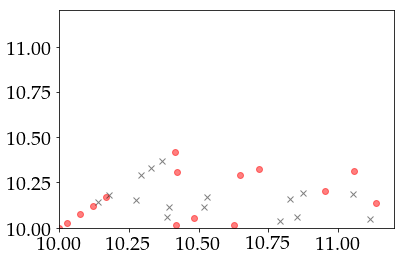

In [82]:
plot(bank01[:,0], bank01[:,1], 'ro', alpha = 0.5)
plot(bank02[:,0], bank02[:,1], 'kx', alpha = 0.5)
xlim(10, 11.2)
ylim(10, 11.2)

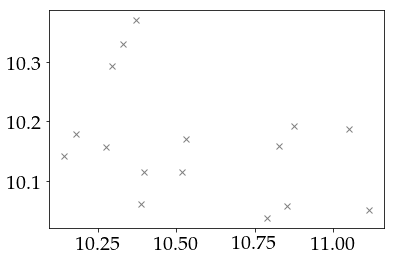

In [80]:
plot(bank02[:,0], bank02[:,1], 'kx', alpha = 0.5)

In [152]:
!gwnrtools_banksim \
    --bank-file-name=bank01.xml \
    --proposal-file-name=bank02.xml \
    --match-file-name=match0102.dat \
    --bank-approximant='EOBNRv2' \
    --proposal-approximant='SEOBNRv4' \
    --psd-model='aLIGOZeroDetHighPower' \
    --mchirp-window=0.1 \
    --sample-rate=4096 \
    --verbose

Could not import ligolw in /home/prayush.kumar/src/GWNRTools/GWNRTools/Stats/FisherMatrixUtilities.pyc, LIGO XML tables wont be read
2020-01-16 21:41:38,327 | INFO : Opening bank file bank01.xml
reading 'bank01.xml' ...
md5sum: 94b7f735401f493c05f27a526624e59e  bank01.xml
2020-01-16 21:41:38,458 | INFO : Opening injections/proposals file bank02.xml
reading 'bank02.xml' ...
md5sum: 5aa28f9535acf7e0396215cb8f2c5329  bank02.xml
2020-01-16 21:41:38,474 | INFO : We have 497 templates and 16 signals / proposals
2020-01-16 21:41:38,474 | INFO : f_min=15.0, sig_len=128, sample_rate=4096, dt=0.000244140625, N=524288
2020-01-16 21:41:38,474 | INFO : Running with CPU support: 1 threads
2020-01-16 21:41:39,165 | INFO : 	 Processing bank batch 1 of 5 (size 100)
2020-01-16 21:41:39,165 | INFO : 		 Processing proposal batch 1 of 1 (size 16)
2020-01-16 21:41:39,165 | INFO : 	 Computing waves for (0, o)
2020-01-16 21:41:39,923 | INFO : 	 Computing waves for (o, 0)
2020-01-16 21:41:46,671 | INFO : 	 Com

2020-01-16 21:42:48,922 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,923 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,924 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,925 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,926 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,927 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,932 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,938 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,939 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,940 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,941 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,942 | WARNING : 	 Skipped (o, 32) due to mchirp
2020-01-16 21:42:48,943 | WARNING : 	 Skipped (o, 33) due to mchirp
2020-01-16 21:42:48,944 | WARNING : 	 Skipped (o, 33) due to mchirp
2020-01-16 21:42:48,946 | WARNING : 	 Skipped (o

2020-01-16 21:42:49,079 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,080 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,081 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,082 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,083 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,084 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,085 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,087 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,088 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,089 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,090 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,091 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,092 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,093 | WARNING : 	 Skipped (o, 40) due to mchirp
2020-01-16 21:42:49,094 | WARNING : 	 Skipped (o

2020-01-16 21:42:49,234 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,235 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,236 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,237 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,238 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,239 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,240 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,241 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,242 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,244 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,245 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,246 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,247 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,248 | WARNING : 	 Skipped (o, 49) due to mchirp
2020-01-16 21:42:49,249 | WARNING : 	 Skipped (o

2020-01-16 21:42:49,389 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,392 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,393 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,394 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,395 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,396 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,397 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,398 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,399 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,400 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,401 | WARNING : 	 Skipped (o, 57) due to mchirp
2020-01-16 21:42:49,403 | WARNING : 	 Skipped (o, 58) due to mchirp
2020-01-16 21:42:49,403 | WARNING : 	 Skipped (o, 58) due to mchirp
2020-01-16 21:42:49,405 | WARNING : 	 Skipped (o, 58) due to mchirp
2020-01-16 21:42:49,406 | WARNING : 	 Skipped (o

2020-01-16 21:42:49,598 | WARNING : 	 Skipped (o, 66) due to mchirp
2020-01-16 21:42:49,600 | WARNING : 	 Skipped (o, 66) due to mchirp
2020-01-16 21:42:49,601 | WARNING : 	 Skipped (o, 66) due to mchirp
2020-01-16 21:42:49,602 | WARNING : 	 Skipped (o, 66) due to mchirp
2020-01-16 21:42:49,603 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,604 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,605 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,606 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,607 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,608 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,609 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,610 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,612 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,613 | WARNING : 	 Skipped (o, 67) due to mchirp
2020-01-16 21:42:49,614 | WARNING : 	 Skipped (o

2020-01-16 21:42:49,753 | WARNING : 	 Skipped (o, 74) due to mchirp
2020-01-16 21:42:49,754 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,755 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,756 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,757 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,758 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,759 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,760 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,760 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,761 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,762 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,763 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,764 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,765 | WARNING : 	 Skipped (o, 75) due to mchirp
2020-01-16 21:42:49,766 | WARNING : 	 Skipped (o

2020-01-16 21:42:49,908 | WARNING : 	 Skipped (o, 82) due to mchirp
2020-01-16 21:42:49,909 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,910 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,911 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,912 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,913 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,914 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,915 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,916 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,917 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,918 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,918 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,919 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,920 | WARNING : 	 Skipped (o, 83) due to mchirp
2020-01-16 21:42:49,921 | WARNING : 	 Skipped (o

2020-01-16 21:42:50,065 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,066 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,067 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,068 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,069 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,070 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,071 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,072 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,073 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,074 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,078 | WARNING : 	 Skipped (o, 91) due to mchirp
2020-01-16 21:42:50,080 | WARNING : 	 Skipped (o, 92) due to mchirp
2020-01-16 21:42:50,081 | WARNING : 	 Skipped (o, 92) due to mchirp
2020-01-16 21:42:50,082 | WARNING : 	 Skipped (o, 92) due to mchirp
2020-01-16 21:42:50,083 | WARNING : 	 Skipped (o

2020-01-16 21:42:50,222 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:50,223 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,224 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,226 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,227 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,228 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,229 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,230 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,231 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,232 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,233 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,234 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,235 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,236 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:50,238 | WARNING : 	 Skipped (o

2020-01-16 21:42:50,378 | WARNING : 	 Skipped (o, 6) due to mchirp
2020-01-16 21:42:50,379 | WARNING : 	 Skipped (o, 6) due to mchirp
2020-01-16 21:42:50,382 | WARNING : 	 Skipped (o, 6) due to mchirp
2020-01-16 21:42:50,383 | WARNING : 	 Skipped (o, 6) due to mchirp
2020-01-16 21:42:50,384 | WARNING : 	 Skipped (o, 6) due to mchirp
2020-01-16 21:42:50,389 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,391 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,392 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,393 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,394 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,395 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,396 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,397 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,398 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:50,400 | WARNING : 	 Skipped (o, 7) due to mc

2020-01-16 21:42:50,585 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:50,589 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:50,590 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:50,591 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:50,592 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:50,593 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,594 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,595 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,596 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,597 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,598 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,599 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,600 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,601 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:50,602 | WARNING : 	 Skipped (o

2020-01-16 21:42:50,792 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:50,793 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:50,795 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:50,796 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:50,797 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,798 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,799 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,800 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,801 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,802 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,803 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,804 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,805 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,806 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:50,807 | WARNING : 	 Skipped (o

2020-01-16 21:42:50,948 | WARNING : 	 Skipped (o, 34) due to mchirp
2020-01-16 21:42:50,949 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,950 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,951 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,952 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,953 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,954 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,955 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,956 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,957 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,958 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,959 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,961 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,962 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:50,963 | WARNING : 	 Skipped (o

2020-01-16 21:42:51,155 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:51,156 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:51,157 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,158 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,159 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,160 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,162 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,163 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,163 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,165 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,166 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,167 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,168 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,169 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:51,170 | WARNING : 	 Skipped (o

2020-01-16 21:42:51,360 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,361 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,362 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,363 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,366 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,367 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,368 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,369 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:51,370 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:51,371 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:51,372 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:51,374 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:51,375 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:51,376 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:51,377 | WARNING : 	 Skipped (o

2020-01-16 21:42:51,517 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,518 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,519 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,520 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,521 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,524 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,525 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:51,526 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,527 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,529 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,530 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,531 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,532 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,533 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:51,534 | WARNING : 	 Skipped (o

2020-01-16 21:42:51,727 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:51,729 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:51,730 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:51,735 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:51,739 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:51,740 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:51,741 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,742 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,743 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,745 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,746 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,747 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,748 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,749 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:51,751 | WARNING : 	 Skipped (o

2020-01-16 21:42:51,985 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,987 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,988 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,989 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,990 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,991 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,992 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,993 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,995 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,996 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,996 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,998 | WARNING : 	 Skipped (o, 80) due to mchirp
2020-01-16 21:42:51,999 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:52,000 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:52,001 | WARNING : 	 Skipped (o

2020-01-16 21:42:52,139 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,140 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,141 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,142 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,143 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,143 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,144 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,147 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,148 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,149 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,150 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,152 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,152 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,153 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:52,154 | WARNING : 	 Skipped (o

2020-01-16 21:42:52,402 | WARNING : 	 Skipped (o, 97) due to mchirp
2020-01-16 21:42:52,405 | WARNING : 	 Skipped (o, 97) due to mchirp
2020-01-16 21:42:52,407 | WARNING : 	 Skipped (o, 97) due to mchirp
2020-01-16 21:42:52,410 | WARNING : 	 Skipped (o, 97) due to mchirp
2020-01-16 21:42:52,412 | WARNING : 	 Skipped (o, 97) due to mchirp
2020-01-16 21:42:52,413 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,414 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,415 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,416 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,417 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,418 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,420 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,421 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,422 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:52,423 | WARNING : 	 Skipped (o

2020-01-16 21:42:52,607 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,608 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,609 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,610 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,611 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,612 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,613 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,614 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,615 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,616 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,616 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,617 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,618 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,619 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:52,621 | WARNING : 	 Skipped (o, 8) due to mc

2020-01-16 21:42:52,763 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,764 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,765 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,766 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,767 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,768 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,769 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,770 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,771 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,771 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,773 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,774 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,774 | WARNING : 	 Skipped (o, 15) due to mchirp
2020-01-16 21:42:52,775 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:52,776 | WARNING : 	 Skipped (o

2020-01-16 21:42:52,971 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,972 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,973 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,974 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,975 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,976 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,976 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,977 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,978 | WARNING : 	 Skipped (o, 25) due to mchirp
2020-01-16 21:42:52,979 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:52,980 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:52,981 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:52,984 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:52,985 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:52,986 | WARNING : 	 Skipped (o

2020-01-16 21:42:53,179 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,180 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,181 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,182 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,183 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,183 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,184 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,186 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,187 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,188 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,189 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,190 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,191 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:53,191 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:53,192 | WARNING : 	 Skipped (o

2020-01-16 21:42:53,335 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,336 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,337 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,338 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,339 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,340 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,341 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,342 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,343 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,344 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,345 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,346 | WARNING : 	 Skipped (o, 44) due to mchirp
2020-01-16 21:42:53,347 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:53,348 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:53,349 | WARNING : 	 Skipped (o

2020-01-16 21:42:53,545 | WARNING : 	 Skipped (o, 52) due to mchirp
2020-01-16 21:42:53,547 | WARNING : 	 Skipped (o, 52) due to mchirp
2020-01-16 21:42:53,548 | WARNING : 	 Skipped (o, 52) due to mchirp
2020-01-16 21:42:53,549 | WARNING : 	 Skipped (o, 52) due to mchirp
2020-01-16 21:42:53,550 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,552 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,555 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,556 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,557 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,559 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,561 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,562 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,563 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,564 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:53,565 | WARNING : 	 Skipped (o

2020-01-16 21:42:53,699 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,701 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,703 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,704 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,705 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,706 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,708 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,709 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,710 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,712 | WARNING : 	 Skipped (o, 60) due to mchirp
2020-01-16 21:42:53,713 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:53,714 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:53,716 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:53,717 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:53,718 | WARNING : 	 Skipped (o

2020-01-16 21:42:53,856 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,857 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,858 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,861 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,862 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,863 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,864 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,866 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,867 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,868 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,869 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,871 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,872 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,873 | WARNING : 	 Skipped (o, 68) due to mchirp
2020-01-16 21:42:53,874 | WARNING : 	 Skipped (o

2020-01-16 21:42:54,064 | WARNING : 	 Skipped (o, 77) due to mchirp
2020-01-16 21:42:54,065 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,066 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,068 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,069 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,070 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,071 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,072 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,073 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,074 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,075 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,076 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,077 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,078 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:54,079 | WARNING : 	 Skipped (o

2020-01-16 21:42:54,220 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,221 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,222 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,223 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,224 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,225 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,226 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,227 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,228 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,229 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,230 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,231 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,232 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,233 | WARNING : 	 Skipped (o, 86) due to mchirp
2020-01-16 21:42:54,234 | WARNING : 	 Skipped (o

2020-01-16 21:42:54,377 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,378 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,379 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,380 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,381 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,387 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,388 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,389 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,390 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,396 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,397 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,398 | WARNING : 	 Skipped (o, 94) due to mchirp
2020-01-16 21:42:54,399 | WARNING : 	 Skipped (o, 95) due to mchirp
2020-01-16 21:42:54,400 | WARNING : 	 Skipped (o, 95) due to mchirp
2020-01-16 21:42:54,401 | WARNING : 	 Skipped (o

2020-01-16 21:42:54,533 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-16 21:42:54,534 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-16 21:42:54,537 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-16 21:42:54,544 | WARNING : 	 Skipped (o, 2) due to mchirp
2020-01-16 21:42:54,545 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,546 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,547 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,548 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,549 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,550 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,551 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,552 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,553 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,554 | WARNING : 	 Skipped (o, 3) due to mchirp
2020-01-16 21:42:54,555 | WARNING : 	 Skipped (o, 3) due to mc

2020-01-16 21:42:54,689 | WARNING : 	 Skipped (o, 10) due to mchirp
2020-01-16 21:42:54,690 | WARNING : 	 Skipped (o, 10) due to mchirp
2020-01-16 21:42:54,691 | WARNING : 	 Skipped (o, 10) due to mchirp
2020-01-16 21:42:54,692 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,693 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,693 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,694 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,696 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,697 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,698 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,699 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,700 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,703 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,704 | WARNING : 	 Skipped (o, 11) due to mchirp
2020-01-16 21:42:54,705 | WARNING : 	 Skipped (o

2020-01-16 21:42:54,899 | WARNING : 	 Skipped (o, 18) due to mchirp
2020-01-16 21:42:54,900 | WARNING : 	 Skipped (o, 18) due to mchirp
2020-01-16 21:42:54,901 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,902 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,903 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,905 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,905 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,906 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,907 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,911 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,912 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,913 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,914 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,915 | WARNING : 	 Skipped (o, 19) due to mchirp
2020-01-16 21:42:54,916 | WARNING : 	 Skipped (o

2020-01-16 21:42:55,053 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:55,054 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:55,055 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,056 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,057 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,058 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,059 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,061 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,062 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,063 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,064 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,065 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,066 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,067 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:55,068 | WARNING : 	 Skipped (o

2020-01-16 21:42:55,212 | WARNING : 	 Skipped (o, 34) due to mchirp
2020-01-16 21:42:55,216 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,218 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,219 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,220 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,225 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,226 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,228 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,229 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,230 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,231 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,236 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,238 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,239 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:55,243 | WARNING : 	 Skipped (o

2020-01-16 21:42:55,419 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,420 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,421 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,422 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,423 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,424 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,425 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,426 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,427 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,428 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:55,430 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:55,431 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:55,432 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:55,433 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:55,434 | WARNING : 	 Skipped (o

2020-01-16 21:42:55,576 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,577 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,578 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,579 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,580 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,581 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,582 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,583 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,589 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:55,590 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:55,591 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:55,593 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:55,594 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:55,595 | WARNING : 	 Skipped (o, 55) due to mchirp
2020-01-16 21:42:55,596 | WARNING : 	 Skipped (o

2020-01-16 21:42:55,733 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,734 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,735 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,735 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,736 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,737 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,738 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:55,739 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,740 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,741 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,743 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,744 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,745 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,746 | WARNING : 	 Skipped (o, 63) due to mchirp
2020-01-16 21:42:55,746 | WARNING : 	 Skipped (o

2020-01-16 21:42:55,891 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,892 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,893 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,893 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,895 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,896 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,902 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,903 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,904 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,905 | WARNING : 	 Skipped (o, 71) due to mchirp
2020-01-16 21:42:55,912 | WARNING : 	 Skipped (o, 72) due to mchirp
2020-01-16 21:42:55,915 | WARNING : 	 Skipped (o, 72) due to mchirp
2020-01-16 21:42:55,916 | WARNING : 	 Skipped (o, 72) due to mchirp
2020-01-16 21:42:55,917 | WARNING : 	 Skipped (o, 72) due to mchirp
2020-01-16 21:42:55,918 | WARNING : 	 Skipped (o

2020-01-16 21:42:56,098 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,100 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,101 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,102 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,103 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,103 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,105 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,106 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,107 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,108 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,113 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,114 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,115 | WARNING : 	 Skipped (o, 81) due to mchirp
2020-01-16 21:42:56,116 | WARNING : 	 Skipped (o, 82) due to mchirp
2020-01-16 21:42:56,119 | WARNING : 	 Skipped (o

2020-01-16 21:42:56,253 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:56,254 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,255 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,257 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,258 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,259 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,260 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,261 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,262 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,265 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,266 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,269 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,270 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,271 | WARNING : 	 Skipped (o, 90) due to mchirp
2020-01-16 21:42:56,272 | WARNING : 	 Skipped (o

2020-01-16 21:42:56,461 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:56,462 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:56,463 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:56,465 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:56,466 | WARNING : 	 Skipped (o, 98) due to mchirp
2020-01-16 21:42:56,468 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,469 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,470 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,471 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,472 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,473 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,474 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,475 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,476 | WARNING : 	 Skipped (o, 99) due to mchirp
2020-01-16 21:42:56,477 | WARNING : 	 Skipped (o

2020-01-16 21:42:56,667 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,668 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,669 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,670 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,670 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,671 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,672 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,673 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,674 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,675 | WARNING : 	 Skipped (o, 7) due to mchirp
2020-01-16 21:42:56,676 | WARNING : 	 Skipped (o, 8) due to mchirp
2020-01-16 21:42:56,677 | WARNING : 	 Skipped (o, 8) due to mchirp
2020-01-16 21:42:56,678 | WARNING : 	 Skipped (o, 8) due to mchirp
2020-01-16 21:42:56,679 | WARNING : 	 Skipped (o, 8) due to mchirp
2020-01-16 21:42:56,680 | WARNING : 	 Skipped (o, 8) due to mc

2020-01-16 21:42:56,822 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:56,824 | WARNING : 	 Skipped (o, 16) due to mchirp
2020-01-16 21:42:56,824 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,825 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,826 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,827 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,828 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,829 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,831 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,832 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,833 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,834 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,835 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,836 | WARNING : 	 Skipped (o, 17) due to mchirp
2020-01-16 21:42:56,836 | WARNING : 	 Skipped (o

2020-01-16 21:42:57,030 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:57,031 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:57,032 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:57,033 | WARNING : 	 Skipped (o, 26) due to mchirp
2020-01-16 21:42:57,034 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,035 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,036 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,037 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,038 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,040 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,041 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,042 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,043 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,044 | WARNING : 	 Skipped (o, 27) due to mchirp
2020-01-16 21:42:57,045 | WARNING : 	 Skipped (o

2020-01-16 21:42:57,195 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:57,198 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:57,199 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:57,205 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:57,207 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:57,210 | WARNING : 	 Skipped (o, 35) due to mchirp
2020-01-16 21:42:57,212 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,214 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,216 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,217 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,219 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,220 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,221 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,222 | WARNING : 	 Skipped (o, 36) due to mchirp
2020-01-16 21:42:57,223 | WARNING : 	 Skipped (o

2020-01-16 21:42:57,391 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,392 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,393 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,395 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,396 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,397 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,398 | WARNING : 	 Skipped (o, 45) due to mchirp
2020-01-16 21:42:57,400 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,402 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,405 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,407 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,408 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,409 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,410 | WARNING : 	 Skipped (o, 46) due to mchirp
2020-01-16 21:42:57,412 | WARNING : 	 Skipped (o

2020-01-16 21:42:57,599 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,600 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,601 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,604 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,606 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,608 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,610 | WARNING : 	 Skipped (o, 53) due to mchirp
2020-01-16 21:42:57,613 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,615 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,618 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,620 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,623 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,625 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,627 | WARNING : 	 Skipped (o, 54) due to mchirp
2020-01-16 21:42:57,632 | WARNING : 	 Skipped (o

2020-01-16 21:42:57,804 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:57,805 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:57,808 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:57,809 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:57,810 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:57,811 | WARNING : 	 Skipped (o, 61) due to mchirp
2020-01-16 21:42:57,812 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,814 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,815 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,816 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,818 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,818 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,820 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,821 | WARNING : 	 Skipped (o, 62) due to mchirp
2020-01-16 21:42:57,824 | WARNING : 	 Skipped (o

2020-01-16 21:42:57,960 | WARNING : 	 Skipped (o, 69) due to mchirp
2020-01-16 21:42:57,961 | WARNING : 	 Skipped (o, 69) due to mchirp
2020-01-16 21:42:57,962 | WARNING : 	 Skipped (o, 69) due to mchirp
2020-01-16 21:42:57,963 | WARNING : 	 Skipped (o, 69) due to mchirp
2020-01-16 21:42:57,969 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,970 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,970 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,971 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,972 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,975 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,976 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,978 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,979 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,979 | WARNING : 	 Skipped (o, 70) due to mchirp
2020-01-16 21:42:57,981 | WARNING : 	 Skipped (o

2020-01-16 21:42:58,116 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,117 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,118 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,119 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,120 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,121 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,122 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,123 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,124 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,125 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,125 | WARNING : 	 Skipped (o, 78) due to mchirp
2020-01-16 21:42:58,126 | WARNING : 	 Skipped (o, 79) due to mchirp
2020-01-16 21:42:58,127 | WARNING : 	 Skipped (o, 79) due to mchirp
2020-01-16 21:42:58,128 | WARNING : 	 Skipped (o, 79) due to mchirp
2020-01-16 21:42:58,129 | WARNING : 	 Skipped (o

2020-01-16 21:42:58,272 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,273 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,274 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,276 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,277 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,277 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,279 | WARNING : 	 Skipped (o, 88) due to mchirp
2020-01-16 21:42:58,280 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,281 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,282 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,283 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,284 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,285 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,286 | WARNING : 	 Skipped (o, 89) due to mchirp
2020-01-16 21:42:58,286 | WARNING : 	 Skipped (o

In [147]:
m_for_all_sigs, m_for_all_templates = parse_match_file('match0102.dat')

/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys


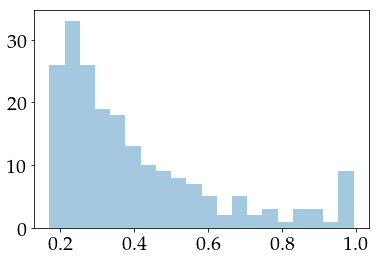

In [150]:
all_y = []
for p in m_for_all_sigs:
    y = get_all_matches_against_point(p, m_for_all_sigs)[0]
    if np.any(y > 0):
        #print("Point {} has some non-trivial matches: {}".format(p, y))
        all_y.extend(y[y > 0])
        hold(True)
hist(all_y, alpha=0.4, bins=20);

/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys


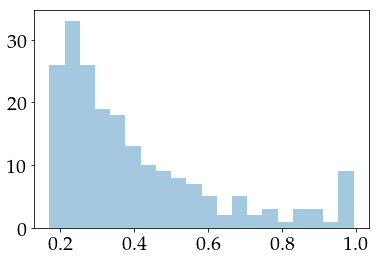

In [149]:
all_y = []
for p in m_for_all_sigs:
    y = get_all_matches_against_point(p, m_for_all_sigs)[0]
    if np.any(y > 0):
        #print("Point {} has some non-trivial matches: {}".format(p, y))
        all_y.extend(y[y > 0])
        hold(True)
hist(all_y, alpha=0.4, bins=20);

In [153]:
!gwnrtools_create_banksim_workflow --help

Usage: gwnrtools_create_banksim_workflow [options]

Options:
  -h, --help       show this help message and exit
  --config=CONFIG  


### Test and debug `gwnrtools_banksim_match_combine`

In [217]:
_ = '''
from os.path import isfile
from optparse import OptionParser
from numpy import *
import glob
parser = OptionParser()

parser.add_option('--inj-num',help="index of the injection set for the match files",type=int)
parser.add_option('-o','--output-file',help="output file with the maximized values")
options, argv_frame_files = parser.parse_args()

fils = glob.glob("match-part/match"+str(options.inj_num)+"part*.dat")

dtypef={'names': ('match', 'bank', 'bank_i', 'sim', 'sim_i', 'sigmasq'), 'formats': ('f8', 'S256', 'i4', 'S256', 'i4', 'f8')}

matches=[]
maxmatch = []
for fil in fils:
    matches.append(loadtxt(fil, dtype=dtypef))

indices = array(matches, dtype=dtypef)['match'].argmax(0)
for i, j in enumerate(indices):
    maxmatch.append(matches[j][i])

maxmatch=array(maxmatch, dtype =dtypef)
savetxt(options.output_file, maxmatch,fmt=('%5.5f', '%s', '%i', '%s', '%i', '%5.5f'), delimiter=' ')
'''

In [210]:
inj_num = 1

In [214]:
fils = glob.glob('match-part/match' + str(inj_num) + 'part*.dat')

In [254]:
m_vals_for_bank_points = {}
m_vals_for_inj_points = {}

for f in fils:
    m_vals_for_bank_points, m_vals_for_inj_points =\
        parse_match_file(f, m_vals_for_bank_points, m_vals_for_inj_points)

In [233]:
x = {1: 2, 3: 4}

In [237]:
np.array(x.values()).argmax(0)

1

In [512]:
with open('tmp_output.dat', 'a') as fout:
    for inj in m_vals_for_inj_points:
        m_vals = np.array(m_vals_for_inj_points[inj].values())
        max_m_idx = m_vals[:,0].argmax(0) # maximum match
        max_m_tmplt = m_vals_for_inj_points[inj].keys()[max_m_idx]
        out_string = "{0}\t{1}\t{2:.12e}\t{3:.12e}\t{4:.12e}\n".format(\
            inj, max_m_tmplt, m_vals[max_m_idx, 0], m_vals[max_m_idx, 1], m_vals[max_m_idx, 2])
        fout.write(out_string)

In [513]:
!cat -n tmp_output.dat

     1	injection/injection351.xml:2	bank/bank0.xml:268	9.922533534614e-01	1.250037728602e-02	1.236529797474e-02
     2	injection/injection351.xml:5	bank/bank0.xml:268	9.754668195245e-01	1.250037728602e-02	1.229766498843e-02
     3	injection/injection351.xml:4	bank/bank0.xml:273	9.956175648420e-01	1.302193911930e-02	1.299190313274e-02
     4	injection/injection86.xml:1	bank/bank0.xml:11	9.898537550565e-01	2.043701539554e-02	2.035153922911e-02
     5	injection/injection351.xml:7	bank/bank0.xml:271	9.811316438232e-01	1.222525921574e-02	1.226502609300e-02
     6	injection/injection351.xml:6	bank/bank0.xml:263	9.895388496490e-01	1.282474784581e-02	1.261902180710e-02
     7	injection/injection76.xml:2	bank/bank0.xml:11	9.897538642354e-01	2.043701539554e-02	2.137283438213e-02
     8	injection/injection76.xml:3	bank/bank0.xml:11	9.897140836608e-01	2.043701539554e-02	2.136931551141e-02
     9	injection/injection76.xml:0	bank/bank0.xml:10	9.865918715826e-01	2.138856884245e-02	2.154321404791e-02


  1761	injection/injection113.xml:3	bank/bank0.xml:15	9.900879052331e-01	1.906336674499e-02	1.910651412381e-02
  1762	injection/injection113.xml:2	bank/bank0.xml:14	9.914827547713e-01	2.035483600559e-02	1.987171072398e-02
  1763	injection/injection113.xml:5	bank/bank0.xml:19	9.892865335424e-01	1.835752562781e-02	1.965719189896e-02
  1764	injection/injection113.xml:4	bank/bank0.xml:14	9.924521418577e-01	2.035483600559e-02	1.994154658408e-02
  1765	injection/injection113.xml:7	bank/bank0.xml:14	9.924181110556e-01	2.035483600559e-02	1.989836812139e-02
  1766	injection/injection113.xml:6	bank/bank0.xml:19	9.886842509791e-01	1.835752562781e-02	1.963429822852e-02
  1767	injection/injection113.xml:9	bank/bank0.xml:18	9.902115133211e-01	1.917980361456e-02	2.006075562319e-02
  1768	injection/injection113.xml:8	bank/bank0.xml:15	9.904365129556e-01	1.906336674499e-02	1.903456814263e-02
  1769	bank/bank0.xml:499	injection/injection393.xml:1	9.912863263216e-01	9.349761157202e-03	9.553856301869e-03


In [224]:
!ligolw_print -c mass1 -t sngl_inspiral bank01.xml | wc -l

497


In [225]:
len(m_vals_for_bank_points[m_vals_for_bank_points.keys()[0]])

10

In [242]:
(m_vals_for_inj_points)

{'00e7258aa5': {'01df6286ad': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '02828039f3': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '02942f381b': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '029d59e30b': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '032b711a87': ('8.624530735962e-01',
   '2.473251492428e-02',
   '2.632222506244e-02'),
  '046e527fc7': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '0509c3be38': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '053d123634': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '058d4dee21': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '065b8795dc': ('-1.000000000000e+00',
   '-1.000000000000e+00',
   '-1.000000000000e+00'),
  '0689423c03': ('-1.000000000000e+00',
   '-1.000000000000

In [264]:
np.array(m_vals_for_inj_points['00e7258aa5'].values())[40, 0]

0.979349913064

In [261]:
m_vals_for_inj_points['00e7258aa5'].keys()[40]

'c9459cf350'

In [262]:
m_vals_for_inj_points['00e7258aa5']['c9459cf350']

[0.979349913064, 0.02612536076372, 0.02632222506244]

### Test and debug `gwnrtools_banksim_collect_results`

In [408]:
_ = '''
from os.path import isfile
from numpy import *
from glue.ligolw import utils, table
import glob

from glue.ligolw import ligolw
from glue.ligolw.ligolw import LIGOLWContentHandler
from glue.ligolw import lsctables
class mycontenthandler(LIGOLWContentHandler):
    pass
lsctables.use_in(mycontenthandler)

fils = glob.glob("match/match*.dat")

dtypem={'names': ('match', 'bank', 'bank_i', 'sim', 'sim_i', 'sigmasq'),\
        'formats': ('f8', 'S256', 'i4', 'S256', 'i4', 'f8')}

# Collect the results
res = None
for fil in fils:
    if res is not None:
        res = append(res, loadtxt(fil, dtype=dtypem))
    else:
        res = loadtxt(fil, dtype=dtypem)
 
btables = {}
itables = {}     

f = open("results.dat", "w")
for row in res: 
    outstr = ""
    if row['bank'] not in btables:
        indoc = utils.load_filename(row['bank'],
                  contenthandler=table.use_in(ligolw.LIGOLWContentHandler),
                                    verbose=True)
        btables[row['bank']] = lsctables.SimInspiralTable.get_table(indoc)
        # indoc = utils.load_filename(row['bank'], False, contenthandler=mycontenthandler)
        # btables[row['bank']] = table.get_table(indoc, "sngl_inspiral") 

    if row['sim'] not in itables:
        indoc = utils.load_filename(row['sim'], False, contenthandler=mycontenthandler)
        itables[row['sim']] = table.get_table(indoc, "sim_inspiral") 
    
    bt = btables[row['bank']][row['bank_i']]     
    it = itables[row['sim']][row['sim_i']]
 
    outstr += str(row['match']) + " "
    outstr += str(bt.mass1) + " "
    outstr += str(bt.mass2) + " "
    outstr += str(bt.spin1x) + " "
    outstr += str(bt.spin1y) + " "
    outstr += str(bt.spin1z) + " "
    outstr += str(bt.spin2x) + " "
    outstr += str(bt.spin2y) + " " 
    outstr += str(bt.spin2z) + " "
    
    outstr += str(it.mass1) + " "
    outstr += str(it.mass2) + " "
    outstr += str(it.spin1x) + " "
    outstr += str(it.spin1y) + " "
    outstr += str(it.spin1z) + " "
    outstr += str(it.spin2x) + " "
    outstr += str(it.spin2y) + " " 
    outstr += str(it.spin2z) + " "
    
    outstr += str(it.coa_phase) + " "
    outstr += str(it.inclination) + " "
    outstr += str(it.latitude) + " " 
    outstr += str(it.longitude) + " "
    outstr += str(it.polarization) + " "
    
    outstr += str(row['sigmasq']) + " "
                
    outstr += "\\n"
    
    f.write(outstr)
'''

In [524]:
def parse_match_file(mfile_name,
                     mvals_for_each_test_point = {},
                     mvals_for_each_bank_point = {}):
    if not os.path.exists(mfile_name):
        raise IOError("Provided file {} not found.".format(mfile_name))
    with open(mfile_name, 'r') as mfile:
        for line in mfile.readlines():
            line = line.split()
            btag, ptag = line[:2]
            if btag not in mvals_for_each_bank_point:
                mvals_for_each_bank_point[btag] = {}
            if ptag not in mvals_for_each_bank_point[btag]:
                mvals_for_each_bank_point[btag][ptag] = list([float(line[2]), float(line[3]), float(line[4])])
            if ptag not in mvals_for_each_test_point:
                mvals_for_each_test_point[ptag] = {}
            if btag not in mvals_for_each_test_point[ptag]:
                mvals_for_each_test_point[ptag][btag] = list([float(line[2]), float(line[3]), float(line[4])])
    return mvals_for_each_test_point, mvals_for_each_bank_point

In [409]:
fils = glob.glob('match/match*.dat')

In [420]:
!cat -n match/match0.dat

     1	injection/injection0.xml:8	bank/bank0.xml:1	9.876070839398e-01	2.677838699559e-02	2.643109057105e-02
     2	injection/injection0.xml:9	bank/bank0.xml:1	9.876363627986e-01	2.677838699559e-02	2.643672198221e-02
     3	injection/injection0.xml:6	bank/bank0.xml:1	9.876436056276e-01	2.677838699559e-02	2.657086561741e-02
     4	injection/injection0.xml:7	bank/bank0.xml:1	9.876617469650e-01	2.677838699559e-02	2.649318577862e-02
     5	injection/injection0.xml:4	bank/bank0.xml:1	9.859348504951e-01	2.677838699559e-02	2.672780194396e-02
     6	injection/injection0.xml:5	bank/bank0.xml:1	9.859850755075e-01	2.677838699559e-02	2.670717753630e-02
     7	injection/injection0.xml:2	bank/bank0.xml:1	9.845905578064e-01	2.677838699559e-02	2.679898682129e-02
     8	injection/injection0.xml:3	bank/bank0.xml:1	9.847982192944e-01	2.677838699559e-02	2.674945512843e-02
     9	injection/injection0.xml:0	bank/bank0.xml:1	9.844265914093e-01	2.677838699559e-02	2.685611284059e-02
    10	injection/injection0.

In [525]:
m_vals_for_bank_points = {}
m_vals_for_inj_points = {}

for f in fils:
    m_vals_for_bank_points, m_vals_for_inj_points =\
        parse_match_file(f, m_vals_for_bank_points, m_vals_for_inj_points)

In [536]:
# Take m_vals_for_inj_points and get SimINspiral row for all the templates
# that best match the injection, and get the SimInspiral row for the 
# injection template as well

# Store this information in a dictionary. What should be the keys?
# the keys should be the injection keys... So we can cross reference
# between raw data and this dictionary easily.

all_xmls = {}
for inj in m_vals_for_inj_points:
    inj_bank_name, inj_row_idx = inj.split(':')
    max_m_tmplt_idx = array([m_vals_for_inj_points[inj][k][0] for k in m_vals_for_inj_points[inj]]).argmax()
    max_m_bank_name, max_m_row_idx = max_m_tag.split(':')
    #print(inj_bank_name)
    # Get SimInspiral row for this injection
    if inj_bank_name not in all_xmls:
        indoc = ligolw_utils.load_filename(inj_bank_name,\
                                           contenthandler=table.use_in(ligolw.LIGOLWContentHandler))
        try: all_xmls[inj_bank_name] = lsctables.SimInspiralTable.get_table(indoc)
        except: all_xmls[inj_bank_name] = lsctables.SnglInspiralTable.get_table(indoc)
    # Get SimInspiral row for the template that best matches it
    if max_m_bank_name not in all_xmls:
        indoc = ligolw_utils.load_filename(max_m_bank_name,\
                                           contenthandler=table.use_in(ligolw.LIGOLWContentHandler))
        try: all_xmls[max_m_bank_name] = lsctables.SimInspiralTable.get_table(indoc)
        except: all_xmls[max_m_bank_name] = lsctables.SnglInspiralTable.get_table(indoc)

In [537]:
with open('results.dat', 'w') as fout:
    for inj in m_vals_for_inj_points:
        inj_bank_name, inj_row_idx = inj.split(':')
        max_m_tmplt_idx = array([m_vals_for_inj_points[inj][k][0] for k in m_vals_for_inj_points[inj]]).argmax()
        max_m_tag = m_vals_for_inj_points[inj].keys()[max_m_tmplt_idx]
        max_m_bank_name, max_m_row_idx = max_m_tag.split(':')
        max_m, max_m_sigmasq, _ = m_vals_for_inj_points[inj][max_m_tag][:]
        inj_row   = all_xmls[inj_bank_name][int(inj_row_idx)]
        max_m_row = all_xmls[max_m_bank_name][int(max_m_row_idx)]
        
        outstr = ""
        outstr += str(max_m) + " "
        outstr += str(max_m_row.mass1) + " "
        outstr += str(max_m_row.mass2) + " "
        outstr += str(max_m_row.spin1x) + " "
        outstr += str(max_m_row.spin1y) + " "
        outstr += str(max_m_row.spin1z) + " "
        outstr += str(max_m_row.spin2x) + " "
        outstr += str(max_m_row.spin2y) + " " 
        outstr += str(max_m_row.spin2z) + " "

        outstr += str(inj_row.mass1) + " "
        outstr += str(inj_row.mass2) + " "
        outstr += str(inj_row.spin1x) + " "
        outstr += str(inj_row.spin1y) + " "
        outstr += str(inj_row.spin1z) + " "
        outstr += str(inj_row.spin2x) + " "
        outstr += str(inj_row.spin2y) + " " 
        outstr += str(inj_row.spin2z) + " "

        outstr += str(inj_row.coa_phase) + " "
        outstr += str(inj_row.inclination) + " "
        outstr += str(inj_row.latitude) + " " 
        outstr += str(inj_row.longitude) + " "
        outstr += str(inj_row.polarization) + " "

        outstr += str(max_m_sigmasq) + " "
        outstr += "\n"
        
        fout.write(outstr)

In [538]:
!tail  results.dat

0.977454099784 25.398482 5.5087072 0.0 0.0 0.0 0.0 0.0 0.0 25.587146 5.4961161 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00800578332033 
0.986424069711 44.248039 44.248039 0.0 0.0 0.0 0.0 0.0 0.0 48.372835 39.929667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0251941529181 
0.985438508497 42.418513 32.698264 0.0 0.0 0.0 0.0 0.0 0.0 46.645732 30.462595 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0218078944896 
0.986833988486 49.572755 35.848573 0.0 0.0 0.0 0.0 0.0 0.0 49.169017 37.6424 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0238785646306 
0.982484007196 11.281016 11.281016 0.0 0.0 0.0 0.0 0.0 0.0 13.507682 9.4072114 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00892420690342 
0.989840859321 47.369858 25.687024 0.0 0.0 0.0 0.0 0.0 0.0 37.03839 34.680469 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0199271157829 
0.989206532395 11.281016 11.281016 0.0 0.0 0.0 0.0 0.0 0.0 13.461566 9.4472495 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00892420690342 
0.995522971405 28.25

### Test and debug `gwnrtools_banksim_plots`

In [546]:
!scripts/gwnrtools_banksim_plots

/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
/home/prayush.kumar/local/venv/pycbc_master_enigma/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


### Visualize test results

In [542]:
from IPython.display import Image

In [540]:
!ls plots

cum_hist.png		 m1-m2-mchirpdiff.png	  q-s2z-match90.png
hist-match-cum.png	 m1-m2-mchirpreldiff.png  q-s2z-match97.png
hist-match.png		 q-s1m-match.png	  q-s2z-match.png
hist-mchirp-diff.png	 q-s1z-match.png	  q-s2z-mchirpdiff.png
hist-mchirp-reldiff.png  q-s1z-mchirpdiff.png	  q-s2z-mchirpreldiff.png
inc-match.png		 q-s1z-mchirpreldiff.png  tm1-tm2-match.png
m1-m2-match.png		 q-s2m-match.png


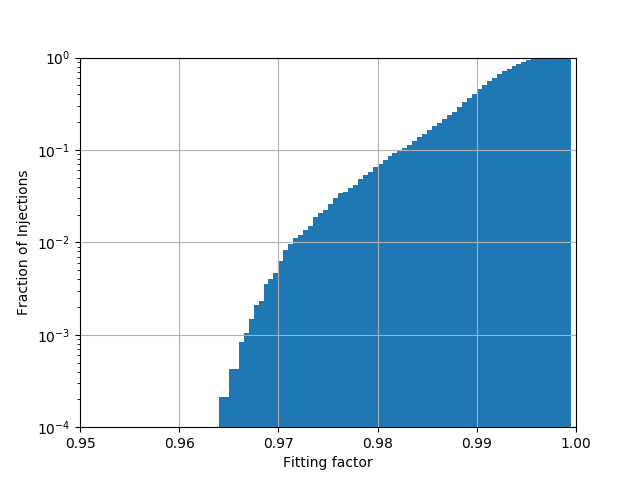

In [544]:
Image('plots/cum_hist.png')

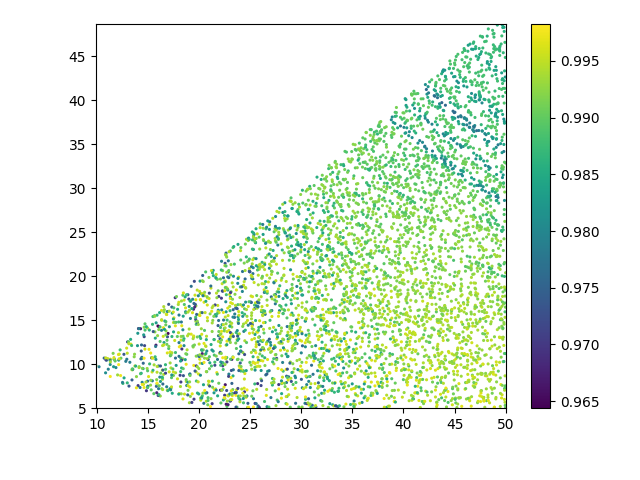

In [547]:
Image('plots/m1-m2-match.png')

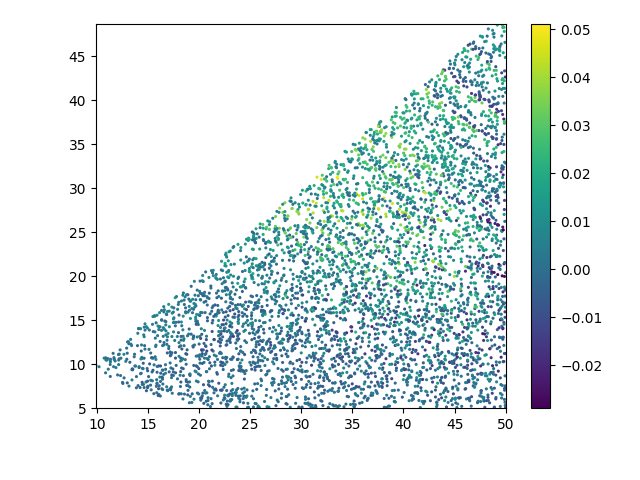

In [548]:
Image('plots/m1-m2-mchirpreldiff.png')